This file contains the code for analysis of singular values and U V. 

The analysis follows Fei on Feb 19, 2023


**Heads-up**

1. When put two grps together, Ctrl first then AD.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from scipy.io import loadmat
from pprint import pprint
from tqdm import trange, tqdm
from scipy.stats import ttest_ind, mannwhitneyu
from collections import defaultdict as ddict
from easydict import EasyDict as edict
from collections import Counter

%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, DATA_ROOT, RES_ROOT, FIG_ROOT

plt.style.use(FIG_ROOT/"base.mplstyle")

In [3]:
from utils.matrix import eig_sorted
from utils.misc import paras2name, cumsum_cutoff, load_pkl_folder2dict, save_pkl_dict2folder
from utils.standardize import minmax, minmax_mat, minmax_pn

## Load data

In [4]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method8"

In [5]:
# load results
cur_res = load_pkl_folder2dict(RES_ROOT/_paras.folder_name, excluding=["Amat*", "can*", "dXX*"])

Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/CPDresult.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ADs_selected.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/cpts_ctrls_selected.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/dwells_ADs_selected.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/dwells_ctrls_selected.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/nXmats_AD.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/nXmats_ctrl.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/ndXmats_AD.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/ndXmats_ctrl.pkl
Load file /gTVDN/notebooks/method8/../../mypkg/../results/method8/post_par

## Analysis

In [16]:
# pool all singular vals together
sing_vals_ADs_pool = np.concatenate(cur_res.singular_vals_ADs, axis=1).T
sing_vals_ctrls_pool = np.concatenate(cur_res.singular_vals_ctrls, axis=1).T
sing_vals_both_pool = np.concatenate([sing_vals_ctrls_pool, sing_vals_ADs_pool], axis=0)

In [39]:
# must remove the scale of the singular values
sing_vals_both_pool_normed = sing_vals_both_pool/np.linalg.norm(sing_vals_both_pool, axis=1)[:, np.newaxis]

### clustering

In [40]:
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA

In [41]:
# find the best num of clusters
def kmeans_BIC(kmCluObj, Cn=1):
    nclu = kmCluObj.n_clusters
    nsps = len(kmCluObj.labels_)
    nDim = kmCluObj.cluster_centers_.shape[1]
    log_lik = np.log(kmCluObj.inertia_/nsps/nDim)
    BIC = log_lik + Cn*np.log(np.log(nsps*nDim))*np.log(nsps)*(nclu-1)/nsps
    #BIC = nsps*log_lik + np.log(nsps)*nclu*nDim/2
    #BIC = nsps*log_lik/(nsps-nDim*nclu)
    #BIC = nsps*log_lik + nclu*nDim
    return BIC

In [47]:
# find the opt num of clusters
BICs = []
num_clus = list(range(2, 20))
for ix in num_clus:
    tmp_clus = KMeans(n_clusters=ix, random_state=0).fit(sing_vals_both_pool_normed)
    BICs.append(kmeans_BIC(tmp_clus,Cn=2))

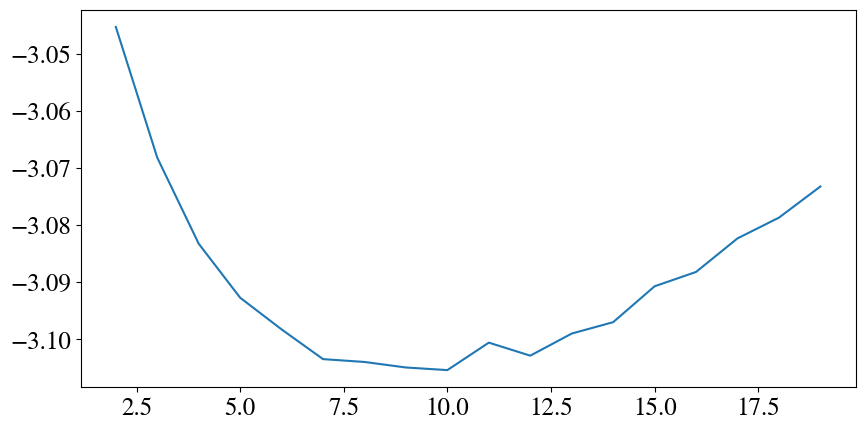

In [48]:
plt.plot(num_clus, BICs)

In [50]:
sel_num_clu = num_clus[np.argmin(BICs)]
sel_num_clu

10